In [1]:
# Set env vars for the relevant model or load from a .env file:
import dotenv
dotenv.load_dotenv()

True

## A multi-agent workflow using LangGraph
### Synopsis
Though AI is far from Skynet, it's powerful if you take the time to tell it what you want.</br>
In this case, using the LangGraph / LangChain libraries building something interesting doesn't take a ton of work. 
### Motivation
Social media is filled with  "gotcha posts" of users showing the results of seemingly clear Chat GPT queries which give nonsensical results. Though these posts help dispel some of the GenAI hype, they imply that the tool is not all that useful. In this case, I got some existing boilerplate code, made a few changes and here you go.

In [2]:
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langgraph_supervisor import create_supervisor
from diffusers import StableDiffusionPipeline
import torch
# determine the type of GPU available
from support import get_device
# Include tools used for the workflow
from local_tools import (
    display_image_grid,
    #genDiffuserImage,
    make_system_prompt,
    pretty_print_messages,
    saveImage,
    saveThumbnail,
    web_search,
)

device = get_device()

# Set env vars for the relevant model or load from a .env file:
import dotenv
dotenv.load_dotenv()

# Define chat model based on llm -- using open source model.
model = init_chat_model("ollama:gpt-oss:20b")
code_model = model

# Define image generation model - using diffusion
model_id = "sd-legacy/stable-diffusion-v1-5"
global pipe 
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

#       For image generation agent using stable diffusion. It makes the image & thumbnail.
def genDiffuserImage(input)->str:
    '''Generate an image of a specific subject 'input'. Then save it, and create a thumbnail'''
    global pipe
    pipe = pipe.to(device)
    images = pipe(f"a cartoon of a {input} in the center of the image")
    nsfw_detected = images.nsfw_content_detected[0]
    if nsfw_detected:
        images = pipe(f"a cartoon of a {input} in the center of the image")
    image = images.images[0]
    image.save(f"{input.capitalize()}.png")
    thumbnail_filename = saveThumbnail(f"{input.capitalize()}.png", f"{input.capitalize()}_thumbnail.png")
    return thumbnail_filename




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
# Define agents

image_generation_agent = create_react_agent(
    model=model,
    tools=[genDiffuserImage],
    name="image_generation_agent",
    prompt=make_system_prompt(
        "You are an image generation agent.\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with image-generation tasks, do not do any research.\n"
        "- You have access to one tool: genDiffuserImage. Use this tool to generate the image based on the user's request, save it, and create a thumbnail of the image."
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
)

image_modify_agent = create_react_agent(
    model=model,
    tools=[saveImage, saveThumbnail],
    name="image_modify_agent",
    prompt=make_system_prompt(
        "You are an image modification agent.\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with image-modification tasks, do not do any research, math or chart generation.\n"
        "- You have access to two tools: saveImage and saveThumbnail. Use these tools to modify and save the image based on the user's request."
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
)

# Research agent
research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_agent",
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math or chart generation\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
)

image_download_agent = create_react_agent(
    model=model,
    tools=[web_search, saveImage, saveThumbnail],
    name="image_download_agent",
    prompt=(
        "You are an image download agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with image download tasks, DO NOT do any math or chart generation\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
)



In [4]:

# Initialize supervisor
supervisor = create_supervisor(
    model=model,
    agents=[research_agent, image_generation_agent,],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent. Do not send any image generation or image storage tasks to this agent. "
        "- an image generation agent. Assign image generation, modification and storage tasks to this agent. "
        "Assign work to one agent at a time, do not call agents in parallel. "
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

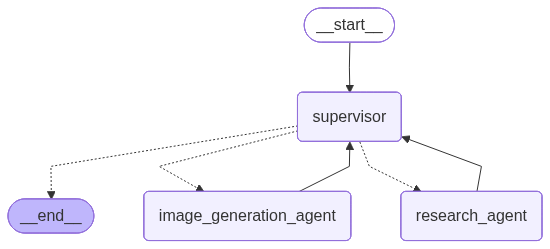

In [5]:
from IPython.display import display, Image
display(Image(supervisor.get_graph().draw_mermaid_png()))

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


{'supervisor': {'messages': [HumanMessage(content="Find a unique, simple noun for each and every letter in the alphabet.\nGenerate an image representing each noun identified. Save the image as '{noun}.png'. Then create a thumbnail of the image. Save the thumbnail as '{noun}_thumbnail.png'.\nWhen all images are generated, finish.", additional_kwargs={}, response_metadata={}, id='798e6bcd-7fd6-4050-a9c1-e3ca69da41ed'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-08-25T20:07:14.10851Z', 'done': True, 'done_reason': 'stop', 'total_duration': 15461985750, 'load_duration': 173761292, 'prompt_eval_count': 277, 'prompt_eval_duration': 317605416, 'eval_count': 1075, 'eval_duration': 14969100667, 'model_name': 'gpt-oss:20b'}, name='supervisor', i

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Update from node image_generation_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


{'image_generation_agent': {'messages': [HumanMessage(content="Find a unique, simple noun for each and every letter in the alphabet.\nGenerate an image representing each noun identified. Save the image as '{noun}.png'. Then create a thumbnail of the image. Save the thumbnail as '{noun}_thumbnail.png'.\nWhen all images are generated, finish.", additional_kwargs={}, response_metadata={}, id='798e6bcd-7fd6-4050-a9c1-e3ca69da41ed'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-08-25T20:07:14.10851Z', 'done': True, 'done_reason': 'stop', 'total_duration': 15461985750, 'load_duration': 173761292, 'prompt_eval_count': 277, 'prompt_eval_duration': 317605416, 'eval_count': 1075, 'eval_duration': 14969100667, 'model_name': 'gpt-oss:2

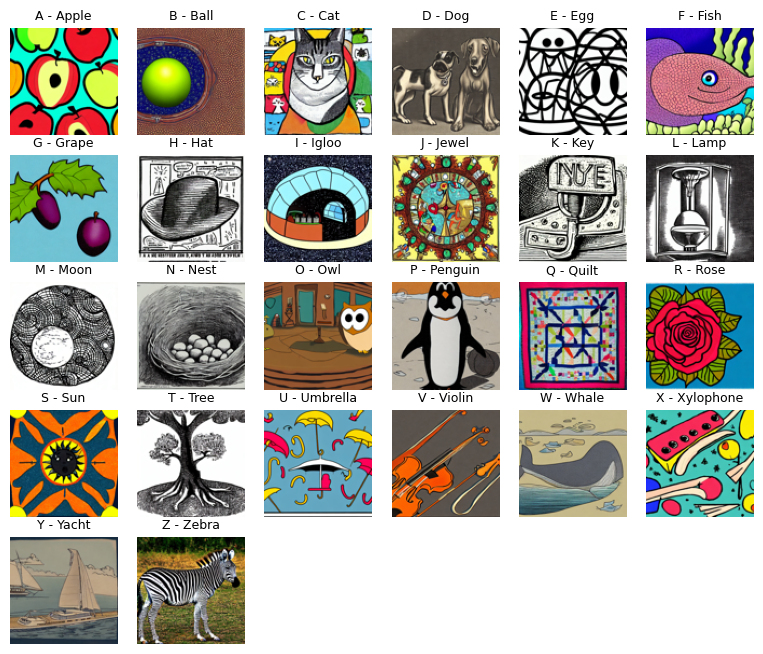

In [6]:
for event in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Find a unique, simple noun for each and every letter in the alphabet.\n"
                "Generate an image representing each noun identified. Save the image as '{noun}.png'. Then create a thumbnail of the image. Save the thumbnail as '{noun}_thumbnail.png'.\n"
                "When all images are generated, finish."
            }
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 550},
):
    pretty_print_messages(event, last_message=True)
    print(event)
display_image_grid()